In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')


In [8]:
def prepare_clustering_features():
    # Create customer transaction features
    customer_features = transactions.groupby('CustomerID').agg({
        'TransactionID': 'count',
        'TotalValue': ['sum', 'mean'],
        'Quantity': ['sum', 'mean']
    })
    # Reshape the columns to a single level and rename for clarity
    customer_features.columns = ['_'.join(col) for col in customer_features.columns]
    customer_features = customer_features.reset_index() # Reset index to have 'CustomerID' as a column

    # Merge with customer data
    customer_features = customers.merge(customer_features, on='CustomerID', how='left')

    # Convert signup date to numeric feature
    customer_features['SignupDate'] = pd.to_datetime(customer_features['SignupDate'])
    customer_features['days_since_signup'] = (customer_features['SignupDate'].max() -
                                            customer_features['SignupDate']).dt.days

    # One-hot encode region
    customer_features = pd.get_dummies(customer_features, columns=['Region'])

    return customer_features


In [4]:
def find_optimal_clusters(features, max_clusters=10):
    scaled_features = StandardScaler().fit_transform(features)

    db_scores = []
    silhouette_scores = []

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        clusters = kmeans.fit_predict(scaled_features)

        db_scores.append(davies_bouldin_score(scaled_features, clusters))
        silhouette_scores.append(silhouette_score(scaled_features, clusters))

    # Plot evaluation metrics
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_clusters + 1), db_scores, marker='o')
    plt.title('Davies-Bouldin Index')
    plt.xlabel('Number of Clusters')

    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.title('Silhouette Score')
    plt.xlabel('Number of Clusters')

    plt.tight_layout()
    plt.show()

    return db_scores, silhouette_scores

In [5]:
def perform_clustering(features, n_clusters):
    # Scale features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)

    # Add cluster labels to features
    clustered_data = features.copy()
    clustered_data['Cluster'] = clusters

    return clustered_data, kmeans

In [9]:
# Prepare features
customer_features = prepare_clustering_features()
features_for_clustering = customer_features.drop(['CustomerID', 'CustomerName', 'SignupDate'], axis=1)

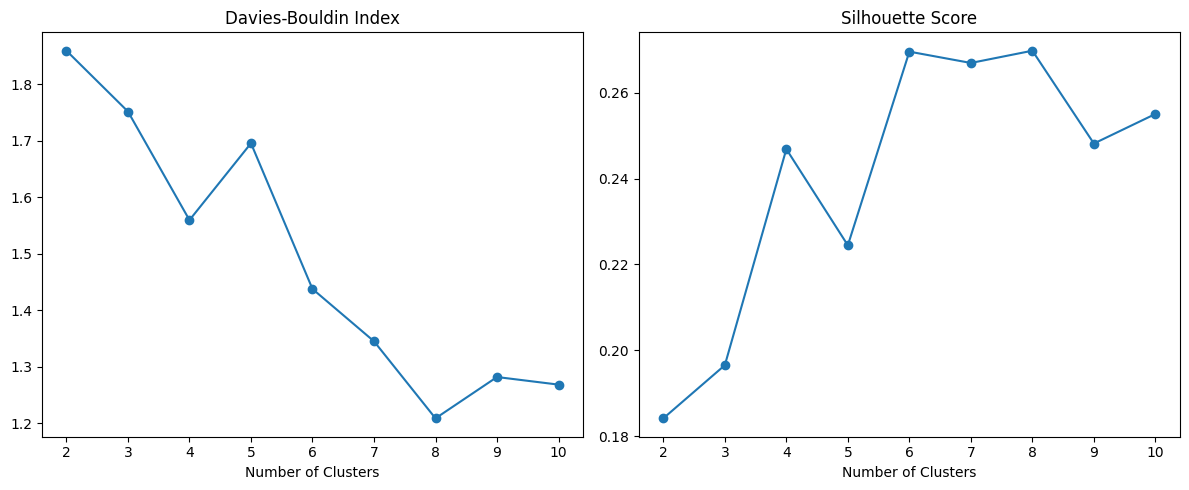

In [11]:
# Impute missing values using the mean of each column
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean') # You can change strategy to 'median' or 'most_frequent'
features_for_clustering = pd.DataFrame(imputer.fit_transform(features_for_clustering), columns=features_for_clustering.columns)
# Find optimal number of clusters
db_scores, silhouette_scores = find_optimal_clusters(features_for_clustering)

In [12]:
optimal_clusters = 4  # Update this based on your analysis

# Perform final clustering
clustered_data, kmeans_model = perform_clustering(features_for_clustering, optimal_clusters)

In [13]:
# Analyze clusters
cluster_summary = clustered_data.groupby('Cluster').agg({
    'TotalValue_sum': 'mean',
    'TransactionID_count': 'mean',
    'Quantity_sum': 'mean',
    'days_since_signup': 'mean'
}).round(2)

print("\nCluster Summary:")
print(cluster_summary)


Cluster Summary:
         TotalValue_sum  TransactionID_count  Quantity_sum  days_since_signup
Cluster                                                                      
0               3054.94                 4.43         11.00             548.00
1               2405.67                 3.84          9.01             551.36
2               5779.46                 7.40         20.69             574.90
3               2890.35                 4.78         11.29             411.98


In [14]:
from sklearn.decomposition import PCA


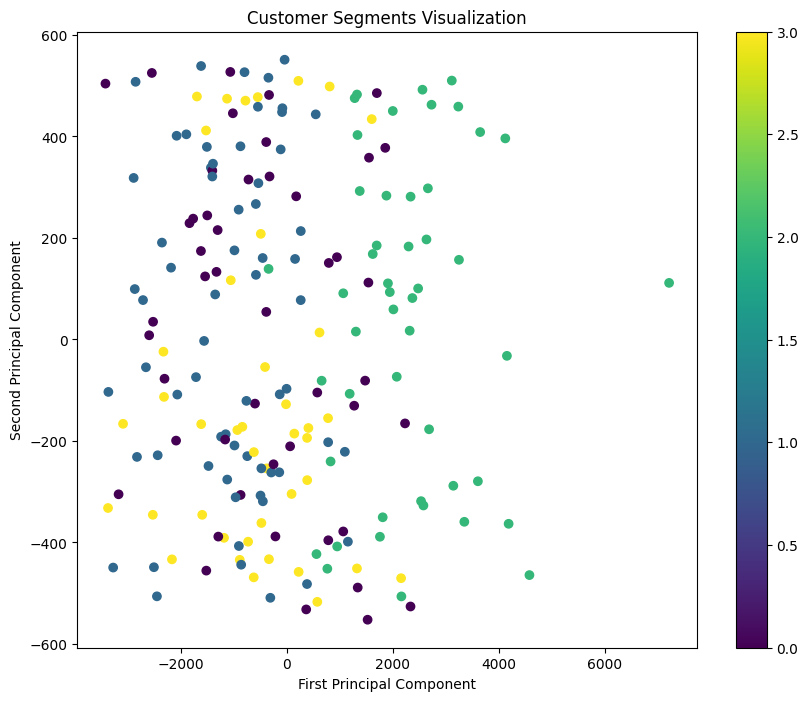

In [15]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features_for_clustering)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1],
                     c=clustered_data['Cluster'], cmap='viridis')
plt.title('Customer Segments Visualization')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter)
plt.show()